In [73]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import pickle
import pymorphy2
import re
import os
import json
import math
from tqdm import tqdm
import random as rand
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')

In [97]:
ls Data

catalog_path  item_details_100000  ozon_train_1000  ratings
catalogs      ozon_test.txt        ozon_train.txt


In [7]:
with open('Data/ozon_test.txt') as f:
    df_test = pd.DataFrame(json.loads(line) for line in f)

In [6]:
with open('Data/ozon_train.txt') as f:
    df_train = pd.DataFrame(json.loads(line) for line in f)

In [142]:
with open('Data/catalog_path') as f:
    df_ctl_path = pd.DataFrame(json.loads(line) for line in f)

In [143]:
with open('Data/catalogs') as f:
    df_ctl = pd.DataFrame(json.loads(line) for line in f)

In [7]:
with open('Data/item_details_100000') as f:
    df_det = pd.DataFrame(json.loads(line) for line in f)

In [ ]:
with open('Data/ratings') as f:
    ratings = pd.DataFrame(json.loads(line) for line in f)

In [9]:
max_len = 0
path_len = []
for row in range(len(df_ctl_path)):
    if len(df_ctl_path.iloc[row]['catalogpath']) > max_len:
        max_len = len(df_ctl_path.iloc[row]['catalogpath'])
    path_len.append(len(df_ctl_path.iloc[row]['catalogpath']))
print max_len

10


Распределение длины пути в дереве каталогов

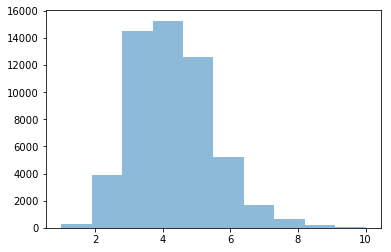

In [10]:
plt.hist(path_len, bins=10, alpha=0.5)
plt.show()

In [ ]:
ctl_pairs = []
ctl_dict ={}
for row in tqdm(range(len(df_ctl_path))):
    for link in range(len(df_ctl_path.iloc[row]['catalogpath'])):
        ctl_dict.update(df_ctl_path.iloc[row]['catalogpath'][link])
        ctl_pairs.append([str(df_ctl_path.iloc[row]['catalogid']),\
                          df_ctl_path.iloc[row]['catalogpath'][link].keys()[0]])







  0%|          | 0/54504 [00:00<?, ?it/s]





  0%|          | 36/54504 [00:00<02:32, 357.32it/s]





  0%|          | 76/54504 [00:00<02:27, 368.43it/s]





  0%|          | 107/54504 [00:00<02:37, 346.16it/s]





  0%|          | 141/54504 [00:00<02:38, 342.35it/s]





  0%|          | 178/54504 [00:00<02:36, 347.43it/s]










  0%|          | 208/54504 [00:00<02:43, 331.65it/s]





  0%|          | 238/54504 [00:00<02:57, 305.89it/s]





  0%|          | 267/54504 [00:00<03:08, 288.13it/s]





  1%|          | 302/54504 [00:00<02:59, 302.63it/s]





  1%|          | 335/54504 [00:01<02:55, 308.62it/s]





  1%|          | 376/54504 [00:01<02:42, 332.22it/s]





  1%|          | 415/54504 [00:01<02:35, 347.04it/s]





  1%|          | 455/54504 [00:01<02:30, 359.16it/s]





  1%|          | 492/54504 [00:01<02:33, 352.03it/s]





  1%|          | 530/54504 [00:01<02:31, 357.39it/s]





  1%|          | 566/54504 [00:01<02:39, 338.33it/s]





  1%|          |

In [ ]:
for key in ctl_dict.keys():
    ctl_dict[key] =ctl_dict.get(key).strip()

Построение графа на базе дерева каталогов

In [ ]:
G_ctl=nx.Graph()
for row in tqdm(range(len(df_ctl_path))):
    G_ctl.add_node(str(df_ctl_path.iloc[row]['catalogid']))

In [ ]:
for pair in ctl_pairs:
    G_ctl.add_edge(pair[0],pair[1])

In [15]:
item_pairs = []
for row in range(len(df_train)):
    for link in df_train.iloc[row]['true_recoms'].items():
        item_pairs.append([str(df_train.iloc[row]['item']),link[0],link[1]])

In [8]:
items = []
for row in range(len(df_train)):
    items.append(df_train.iloc[row]['item'])
    for link in df_train.iloc[row]['true_recoms'].items():
        items.append(link[0])
print len(items)
for row in range(len(df_train)):
    items.append(df_train.iloc[row]['item'])
print len(items)

1061250
1203688


In [17]:
len(df_ctl.itemid.unique())

6732538

In [18]:
len(pd.DataFrame(items,columns=['items'])['items'].unique())

376357

In [19]:
len(item_pairs)

918812

In [22]:
df_item_pairs = pd.DataFrame(item_pairs, columns=['source','target', 'y'])
df_item_pairs = pd.merge(left=df_item_pairs, right=df_ctl.drop_duplicates(['itemid']), left_on='source',right_on='itemid', how='inner')
del df_item_pairs['itemid']
df_item_pairs.rename(columns={'catalogid': 'source_ctl'},inplace=True)
df_item_pairs = pd.merge(left=df_item_pairs, right=df_ctl.drop_duplicates(['itemid']), left_on='target',right_on='itemid', how='inner')
del df_item_pairs['itemid']
df_item_pairs.rename(columns={'catalogid': 'target_ctl'},inplace=True)

In [23]:
ratings.itemid = ratings['itemid'].astype(str)

df_item_pairs = pd.merge(df_item_pairs,ratings,left_on='source',right_on='itemid',how='left')
del df_item_pairs['itemid']
df_item_pairs.rename(columns={'rating': 'source_rating'},inplace=True)

df_item_pairs = pd.merge(df_item_pairs,ratings,left_on='target',right_on='itemid', how='left')
del df_item_pairs['itemid']
df_item_pairs.rename(columns={'rating': 'target_rating'},inplace=True)

In [24]:
df_item_pairs['y_log'] = np.log(df_item_pairs.sort_values(by='y', ascending=False)['y'])+1

In [25]:
df_item_pairs.shape

(837075, 8)

Построение графа на базе категорий связанных в трейне через рекомендации

In [26]:
len(df_ctl.catalogid.unique())

4780

In [27]:
G_item_ctl=nx.Graph()
for ctl in tqdm(list(df_ctl.catalogid.unique())):
    G_item_ctl.add_node(ctl)

100%|██████████| 4780/4780 [00:00<00:00, 273095.68it/s]


Построение связей в графе item_ctl на базе train

In [28]:
for pair in tqdm(range(len(df_item_pairs))):
    G_item_ctl.add_edge(df_item_pairs.iloc[pair]['source_ctl'], df_item_pairs.iloc[pair]['target_ctl'])

100%|██████████| 837075/837075 [07:11<00:00, 1939.65it/s]


In [29]:
df_item_pairs.groupby('y').size()[:10]

y
1     458437
2     122665
3      45853
4      20963
5      50379
6      15982
7       8213
8       4774
9       3138
10      3582
dtype: int64

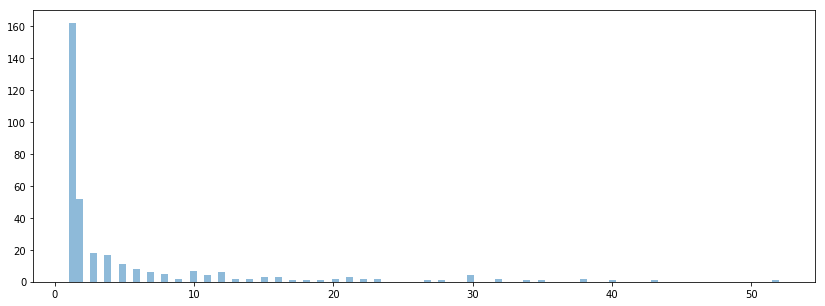

In [30]:
plt.figure(figsize=[14,5])
plt.hist(df_item_pairs.groupby('y').size()[70:], bins=100, alpha=0.5)
plt.show()

Степень узла для каждой категории товара на базе графа в дереве каталога

In [31]:
df_item_pairs['source_degree_ctl'] = df_item_pairs['source_ctl'].apply(lambda x: nx.degree(G_ctl,x))
df_item_pairs['target_degree_ctl'] = df_item_pairs['target_ctl'].apply(lambda x: nx.degree(G_ctl,x))

Степень узла для каждой категории товара на базе графа категорий для пар рекомендаций

In [32]:
df_item_pairs['source_degree_item_ctl'] = df_item_pairs['source_ctl'].apply(lambda x: nx.degree(G_item_ctl,x))
df_item_pairs['target_degree_item_ctl'] = df_item_pairs['target_ctl'].apply(lambda x: nx.degree(G_item_ctl,x))

Среднее степень узлов плижайшего окружения на базе графа в дереве каталога

In [33]:
avg_nei_degree_dict = nx.average_neighbor_degree(G_ctl)
df_item_pairs['source_avg_nei_degree'] = df_item_pairs['source_ctl'].apply(lambda x: avg_nei_degree_dict[x])
df_item_pairs['target_avg_nei_degree'] = df_item_pairs['target_ctl'].apply(lambda x: avg_nei_degree_dict[x])

Среднее степень узлов плижайшего окружения на базе графа категорий для пар рекомендаций

In [34]:
avg_nei_degree_dict_item_ctl = nx.average_neighbor_degree(G_item_ctl)
df_item_pairs['source_avg_nei_degree_item_ctl'] = df_item_pairs['source_ctl'].apply(lambda x: avg_nei_degree_dict_item_ctl[x])
df_item_pairs['target_avg_nei_degree_item_ctl'] = df_item_pairs['target_ctl'].apply(lambda x: avg_nei_degree_dict_item_ctl[x])

Функция для поиска общих категорий на базе графа в дереве каталога

In [35]:
df_item_pairs['common_neighbors_ctl'] = df_item_pairs. \
                    apply(lambda x: len(list(nx.common_neighbors(G_ctl, x['source_ctl'], x['target_ctl']))), axis=1)

Функция для поиска общих категорий на базе графа категорий для пар рекомендаций

In [36]:
df_item_pairs['common_neighbors_item_ctl'] = df_item_pairs. \
                    apply(lambda x: len(list(nx.common_neighbors(G_item_ctl, x['source_ctl'], x['target_ctl']))), axis=1)

Длина кратчайшего пути на базе графа в дереве каталога

In [37]:
df_item_pairs['short_path_ctl'] = df_item_pairs. \
                    apply(lambda x: nx.shortest_path_length(G_ctl, x['source_ctl'], x['target_ctl']), axis=1)

Длина кратчайшего пути на базе графа категорий для пар рекомендаций

In [38]:
df_item_pairs['short_path_item_ctl'] = df_item_pairs. \
                    apply(lambda x: nx.shortest_path_length(G_item_ctl, x['source_ctl'], x['target_ctl']), axis=1)

Метрика Jaccard для графов на путях категорий

In [40]:
def Jaccard_ctl(row):
    if row['source_degree_ctl']+row['target_degree_ctl']-row['common_neighbors_ctl'] != 0:
        return row['common_neighbors_ctl']/float(row['source_degree_ctl']+row['target_degree_ctl']-row['common_neighbors_ctl'])
    else:
        return -1
    
df_item_pairs['Jaccard_ctl'] = df_item_pairs.apply(Jaccard_ctl, axis=1)

Метрика Jaccard для графов на комбинации пар

In [41]:
def Jaccard_item_ctl(row):
    if row['source_degree_item_ctl']+row['target_degree_item_ctl']-row['common_neighbors_item_ctl'] != 0:
        return row['common_neighbors_item_ctl']/float(row['source_degree_item_ctl']+row['target_degree_item_ctl']-row['common_neighbors_item_ctl'])
    else:
        return -1

df_item_pairs['Jaccard_item_ctl'] = df_item_pairs.apply(Jaccard_item_ctl, axis=1)

In [42]:
def Sorensen_ctl(row):
    if row['source_degree_ctl']*row['target_degree_ctl'] != 0:
        return 2*row['common_neighbors_ctl']/float(row['source_degree_ctl']+row['target_degree_ctl'])
    else:
        return -1

df_item_pairs['Sorensen_ctl'] = df_item_pairs.apply(Sorensen_ctl, axis=1)

In [43]:
def Sorensen_item_ctl(row):
    if row['source_degree_item_ctl']*row['target_degree_item_ctl'] != 0:
        return 2*row['common_neighbors_item_ctl']/float(row['source_degree_item_ctl']+row['target_degree_item_ctl'])
    else:
        return -1

df_item_pairs['Sorensen_item_ctl'] = df_item_pairs.apply(Sorensen_item_ctl, axis=1)

In [44]:
def LHNI_ctl(row):
    if row['source_degree_ctl']*row['target_degree_ctl'] != 0:
        return row['common_neighbors_ctl']/float(row['source_degree_ctl']*row['target_degree_ctl'])
    else:
        return -1

df_item_pairs['LHNI_ctl'] = df_item_pairs.apply(LHNI_ctl, axis=1)

In [45]:
def LHNI_item_ctl(row):
    if row['source_degree_item_ctl']*row['target_degree_item_ctl'] != 0:
        return row['common_neighbors_item_ctl']/float(row['source_degree_item_ctl']*row['target_degree_item_ctl'])
    else:
        return -1
    
df_item_pairs['LHNI_item_ctl'] = df_item_pairs.apply(LHNI_item_ctl, axis=1)

In [46]:
def Adamic_Adar_ctl(row):
    summ = 0
    try:
        neighbors = nx.common_neighbors(G_ctl,row['source_ctl'],row['target_ctl'])
    except nx.NetworkXNoPath:
        return -1
    for n in neighbors:
        try:
            A_A = 1/math.log(G_ctl.degree(n))
        except nx.NetworkXNoPath:
            return -1
        summ = summ + A_A
    return summ
df_item_pairs['Adamic_Adar_ctl'] = df_item_pairs.apply(Adamic_Adar_ctl, axis=1)

In [50]:
def Adamic_Adar_item_ctl(row):
    summ = 0
    try:
        neighbors = nx.common_neighbors(G_item_ctl,row['source_ctl'],row['target_ctl'])
    except nx.NetworkXNoPath:
        return -1
    for n in neighbors:
        try:
            A_A = 1/math.log(G_item_ctl.degree(n))
        except:
            return -1
        summ = summ + A_A
    return summ
df_item_pairs['Adamic_Adar_item_ctl'] = df_item_pairs.apply(Adamic_Adar_item_ctl, axis=1)

In [ ]:
df_item_pairs.shape

In [3]:
df_item_pairs = pd.read_pickle('df_item_pairs.pkl')

In [4]:
df_item_pairs.iloc[100:105,:]

,source,target,y,source_ctl,target_ctl,source_rating,target_rating,y_log,source_degree_ctl,target_degree_ctl,...,short_path_ctl,short_path_item_ctl,Jaccard_ctl,Jaccard_item_ctl,Sorensen_ctl,Sorensen_item_ctl,LHNI_ctl,LHNI_item_ctl,Adamic_Adar_ctl,Adamic_Adar_item_ctl
100,6200003,21458776,5,1138676,1139400,2.333333,NaN,2.609438,8,6,...,2,1,0.272727,0.209003,0.428571,0.345745,0.062500,0.002284,0.379509,13.771354
101,5705796,21458776,1,1138654,1139400,4.250000,NaN,1.000000,8,6,...,2,1,0.272727,0.177852,0.428571,0.301994,0.062500,0.002445,0.379509,11.228984
102,30232057,30232028,1,1179519,1159236,NaN,NaN,1.000000,6,6,...,2,1,0.090909,0.250000,0.166667,0.400000,0.027778,0.006764,0.113649,5.245349
103,28723926,30232028,1,1179519,1159236,NaN,NaN,1.000000,6,6,...,2,1,0.090909,0.250000,0.166667,0.400000,0.027778,0.006764,0.113649,5.245349
104,30232057,30232031,1,1179519,1179519,NaN,NaN,1.000000,6,6,...,0,0,0.500000,0.949367,0.666667,0.974026,0.111111,0.012650,0.838209,16.137247


In [52]:
df_det[['parent_id','itemid','attr0','attr1','attr2','attr10','attr32','attr38','attr5','attr6']].head(10)

,parent_id,itemid,attr0,attr1,attr2,attr10,attr32,attr38,attr5,attr6
0,17969540,12808031,<B> Прижизненное издание.</B><BR> С.-Петербург...,История маленького лорда,Ф. Бернет,NaN,Русский,NaN,NaN,NaN
1,16095306,12599476,Надежная защита - благодаря сверхтонкому плотн...,"Belkin чехол для iPad 2 Snap Shield, Smoke",NaN,Belkin,NaN,Унисекс,Сумки-чехлы-рюкзаки для планшетов,NaN
2,NaN,22440986,нет,"Толковый словарь русского языка. 100000 слов, ...",С. И. Ожегов,NaN,NaN,NaN,NaN,NaN
3,NaN,22441264,нет,Архитектурное творчество СССР. Выпуск 6,NaN,NaN,NaN,NaN,NaN,NaN
4,22476179,22466267,"Дорогие друзья!<br> Проект ""Ты родился"" предла...","Видео-открытка ""Ты родился!"": 1940 год",NaN,NaN,NaN,NaN,NaN,NaN
5,22611447,22500510,Удобные ботинки West Club выполнены из натурал...,Ботинки West Club SLHA816-6-1A. Цвет: Черный. ...,NaN,West Club,NaN,Муж.,NaN,NaN
6,22517964,22501357,Отличные ботинки Betsy выполнены из замши кори...,Ботинки Betsy 329296/01#5. Цвет: Коричневый. Р...,NaN,Betsy,NaN,Жен.,NaN,NaN
7,NaN,22437755,Предлагаем вашему вниманию повесть Владимира К...,Побег в соловьиные зори,Владимир Кобликов,NaN,Русский,NaN,NaN,NaN
8,23139002,22449833,"Весело, с азартом провести время в кругу семьи...",Играем в кости. 124 игры для взрослых и детей,Райнер Книзиа,NaN,Русский,NaN,NaN,NaN
9,NaN,22385799,- Карта города (масштаб: 1:13000); <br> - Цент...,Милан. Карта,NaN,NaN,Русский Английский Испанский,NaN,NaN,NaN


In [53]:
group_size_pair = df_item_pairs.groupby(['source_ctl','target_ctl']).size().reset_index()
group_sum_y = df_item_pairs.groupby(['source_ctl','target_ctl'])['y'].sum().reset_index()

In [54]:
df_pair_ctl_sum = pd.merge(group_size_pair,group_sum_y,on=['source_ctl','target_ctl'])
df_pair_ctl_sum = df_pair_ctl_sum.rename(columns={0: 'sum_pair', 'y': 'sum_y'})
df_pair_ctl_sum['multy_sum'] = df_pair_ctl_sum['sum_pair']*df_pair_ctl_sum['sum_y']
df_pair_ctl_sum['sum_of_sum'] = df_pair_ctl_sum['sum_pair']+df_pair_ctl_sum['sum_y']

In [55]:
group_mult_sum = df_pair_ctl_sum.groupby('source_ctl')['target_ctl', 'multy_sum'].sum().reset_index()

def div_mult_globSum(row):
    glob_ctl_sum = group_mult_sum[group_mult_sum.source_ctl==row.source_ctl]['multy_sum']
    return float(row.multy_sum / glob_ctl_sum)
df_pair_ctl_sum['div_mult_globSum'] = df_pair_ctl_sum.apply(div_mult_globSum,axis=1)

In [56]:
df_pair_ctl_sum.to_pickle('df_pair_ctl_sum.pkl')

In [60]:
df_pair_ctl_sum.head(10)

,source_ctl,target_ctl,sum_pair,sum_y,multy_sum,sum_of_sum,div_mult_globSum
0,1085273,1085268,1,3,3,4,0.187500
1,1085273,1103161,1,1,1,2,0.062500
2,1085273,1148461,1,3,3,4,0.187500
3,1085273,1152820,1,2,2,3,0.125000
4,1085273,1152826,1,2,2,3,0.125000
5,1085273,1152835,1,5,5,6,0.312500
6,1085582,1130632,6,11,66,17,0.402439
7,1085582,1138286,2,6,12,8,0.073171
8,1085582,1138289,1,5,5,6,0.030488
9,1085582,1138301,1,1,1,2,0.006098


In [13]:
len(df_item_pairs[df_item_pairs.target_ctl=='1130632']['target'])

78

In [61]:
df_pair_cos = df_item_pairs.fillna(0)#df_item_pairs.mean())

In [73]:
from sklearn.metrics.pairwise import cosine_similarity

df_pair_cos = df_item_pairs.convert_objects(convert_numeric=True)
for n in range(10):
    print cosine_similarity(df_pair_cos.iloc[0], df_pair_cos.iloc[n+100])

[[ 0.87536607]]
[[ 0.86486024]]
[[ 0.99999739]]
[[ 0.9996682]]
[[ 0.99999664]]
[[ 0.99999664]]
[[ 0.99999664]]
[[ 0.9999654]]
[[ 0.99999942]]
[[ 0.99999942]]


In [74]:
%%time
np_scaled = MinMaxScaler().fit_transform(df_item_pairs)
df_normalized = pd.DataFrame(np_scaled)
df_normalized

CPU times: user 3.17 s, sys: 183 ms, total: 3.35 s
Wall time: 3.35 s


In [75]:
print cosine_similarity(df_normalized.iloc[0], df_normalized.iloc[n+100])

[[ 0.98598419]]


Создаем пространство обьектов

In [9]:
df_items = pd.DataFrame(items,columns=['items'])

In [10]:
df_items = df_items.drop_duplicates()

In [13]:
df_items = pd.merge(left=df_items, right=df_ctl.drop_duplicates(['itemid']), left_on='items',right_on='itemid', how='inner')
del df_items['itemid']
df_items.rename(columns={'catalogid': 'item_ctl'},inplace=True)

In [14]:
df_items.head()

,items,item_ctl
0,31471303,1146150
1,31471373,1146150
2,31471307,1146134
3,31471342,1146134
4,31489016,1134295


In [ ]:
df_items['item_degree_ctl'] = df_items['item_ctl'].apply(lambda x: nx.degree(G_ctl,x))

In [ ]:
df_items['item_degree_item_ctl'] = df_items['item_ctl'].apply(lambda x: nx.degree(G_item_ctl,x))

In [ ]:
avg_nei_degree_dict = nx.average_neighbor_degree(G_ctl)
df_items['item_avg_nei_degree'] = df_items['item_ctl'].apply(lambda x: avg_nei_degree_dict[x])

In [ ]:
avg_nei_degree_dict_item_ctl = nx.average_neighbor_degree(G_item_ctl)
items['source_avg_nei_degree_item_ctl'] = items['source_ctl'].apply(lambda x: avg_nei_degree_dict_item_ctl[x])

In [16]:
import os
import sys

os.environ["PYSPARK_SUBMIT_ARGS"]='--packages com.databricks:spark-csv_2.10:1.2.0 pyspark-shell'
spark_home = os.environ.get('SPARK_HOME', None)
sys.path.insert(0, spark_home + "/python")

execfile(os.path.join(spark_home, 'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.1.1
      /_/

Using Python version 2.7.6 (default, Oct 26 2016 20:30:19)
SparkSession available as 'spark'.


In [17]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, avg, concat, udf, array
from pyspark.ml.feature import Tokenizer
from pyspark.sql.types import IntegerType, StringType, ArrayType, FloatType, DoubleType, StructType, StructField
from pyspark.ml.feature import Word2Vec,VectorAssembler
from pyspark.ml.clustering import KMeans

from sklearn.metrics.pairwise import cosine_similarity

import re
import string

In [18]:
df = spark.read.json('/labs/project2/item_details_full')
df = df.fillna('')

In [19]:
df_concat = df.withColumn('concat_text', concat(col('attr0'),col('attr1'))).select('concat_text', 'itemid')

In [20]:
def clearText(text):
    text = text.lower().strip()
    text = re.sub(ur"[^а-яА-ЯёЁ\s]","", text)
    return text
clear = udf(clearText, StringType())
df_clear = df_concat.withColumn('clear_text', clear(df_concat.concat_text)).select('clear_text', 'itemid')

In [21]:
tokenizer = Tokenizer(inputCol='clear_text', outputCol="w_sent")
tokenized = tokenizer.transform(df_clear)
df_sent =tokenized.select("w_sent", "itemid")

In [22]:
spark_items = spark.createDataFrame(df_items)

In [23]:
df_s = spark_items.join(df_sent, spark_items.items == df_sent.itemid).select('items','item_ctl','w_sent')#('items','item_ctl','item_degree_ctl','item_degree_item_ctl','item_avg_nei_degree','w_sent')

In [24]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

model = KeyedVectors.load_word2vec_format('web_0_300_20.bin', binary=True)
morph = pymorphy2.MorphAnalyzer()

with open ('stop_words', 'rb') as fp:
    stop_words = pickle.load(fp)

from pyspark.ml.linalg import Vectors, VectorUDT
index2word_set = set(model.index2word)

def text_to_vec(words):
    text_vec = np.zeros((300,), dtype="float32")
    n_words = 0
    

    for word in words:
        parse = morph.parse(word)[0]
        word = parse[2]+'_'+str(parse[1]).split(',')[0]
        if word in index2word_set and not word in stop_words:
            n_words = n_words + 1
            text_vec = np.add(text_vec, model[word])
    if n_words != 0:
        text_vec /= n_words
    return Vectors.dense(text_vec.tolist())

udf_text_to_vec = udf(text_to_vec, VectorUDT())#ArrayType(FloatType()))
df_w2v = df_s.withColumn('w2v', udf_text_to_vec(df_s.w_sent))

In [30]:
df_w2v = df_w2v.withColumn("items", df_w2v["items"].cast("integer"))\
               .withColumn("item_ctl", df_w2v["item_ctl"].cast("integer"))\
               #.withColumn("item_degree_ctl", df_w2v["item_degree_ctl"].cast("double"))\
               #.withColumn("item_degree_item_ctl", df_w2v["item_degree_item_ctl"].cast("double"))\
               #.withColumn("item_avg_nei_degree", df_w2v["item_avg_nei_degree"].cast("double"))

In [31]:
df_w2v.printSchema()

root
 |-- items: integer (nullable = true)
 |-- item_ctl: integer (nullable = true)
 |-- w_sent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- w2v: vector (nullable = true)



In [34]:
vecAssembler = VectorAssembler(inputCols=["items", "w2v", "item_ctl","item_degree_ctl","item_degree_item_ctl","item_avg_nei_degree"], outputCol="features")

In [35]:
vec = vecAssembler.transform(df_w2v)

In [ ]:
vec.show(5)

+-------+--------+--------------------+--------------------+--------------------+
|  items|item_ctl|              w_sent|                 w2v|            features|
+-------+--------+--------------------+--------------------+--------------------+
|1021617| 1138589|[издание, , года,...|[0.02316781319677...|[1021617.0,0.0231...|
| 103634| 1138360|[ицзин, или, книг...|[0.01195986755192...|[103634.0,0.01195...|
|1114663| 1141109|                  []|[0.0,0.0,0.0,0.0,...|(302,[0,301],[111...|
|1116805| 1143133|                  []|[0.0,0.0,0.0,0.0,...|(302,[0,301],[111...|
|1116813| 1142829|                  []|[0.0,0.0,0.0,0.0,...|(302,[0,301],[111...|
+-------+--------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
kmeans = KMeans(k=3400, seed=1)
model = kmeans.fit(vec)

In [55]:
model.summary.predictions.printSchema()

root
 |-- items: integer (nullable = true)
 |-- item_ctl: integer (nullable = true)
 |-- w_sent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- w2v: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: integer (nullable = true)



In [57]:
df_kmeans_items = model.summary.predictions.select('items','item_ctl','prediction').toPandas()

In [ ]:
test = []

for row in range(len(df_test)):
    if len(df_kmeans_items[df_kmeans_items['items'] == int(df_test.iloc[row]['item'])])!=0:
        predict = df_kmeans_items[df_kmeans_items['items'] == int(df_test.iloc[row]['item'])]['prediction'].values[0]
        cluster = df_kmeans_items[df_kmeans_items['prediction'] == predict]
        for item in range(len(cluster)):
            if int(df_test.iloc[row]['item']) != cluster.iloc[item]['items']:
                test.append([int(df_test.iloc[row]['item']), cluster.iloc[item]['items']])

In [139]:
df = pd.DataFrame(test,columns=['item','rec'])